In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import glob
import time
import tensorflow as tf
from tensorflow.python.keras import layers
from keras.layers import Rescaling

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
dim=100

def Extract_Images_Test(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))


def Extract_Images(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        img=cv.resize(img,dsize=[100, 100])
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,0),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,-1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))

In [3]:
Folders=os.listdir('C:/Users/antoi/Dropbox/PC/Desktop/Images')
print(len(Folders))

120


# **Extending the models to the whole DataFrame**


In [4]:
num_classes=120

In [5]:
data=pd.DataFrame(columns=['Image','Race','RaceId'],dtype=np.float32)

In [6]:
i=0
for Folder in Folders[:num_classes]:
    tempdata=Extract_Images(Folder)
    data=pd.concat([data,pd.concat([tempdata,pd.DataFrame([i]*(tempdata.shape[0]),columns=['RaceId'])],axis=1)])
    if i%20==0:
        print(i)
    i+=1

0
20
40
60
80
100


In [7]:
data.reset_index(inplace=True)
print(data.shape)

(82320, 4)


In [8]:
class_names=pd.unique(data['Race'])

In [9]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [10]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [11]:
data_original=data.copy()

In [12]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.005*dst.max()]=[255,0,0]
    if k%10000==0:
        print(k)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [13]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [14]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [15]:
data=pd.concat([data,data_original],axis=0)
data_original=data.copy()

In [16]:
data.reset_index(inplace=True)

print(data.shape)

(164640, 6)


In [17]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(img, None)
    img=cv.drawKeypoints(gray,kp,img)
    if k%10000==0:
        print(k)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000


In [18]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [19]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [20]:
data=pd.concat([data,data_original],axis=0)
data=data.drop(['level_0','index'],axis=1)
data.reset_index(inplace=True)
print(data.shape)

(329280, 5)


## Pre processing of the data


In [21]:
train_image,test_image,train_label, test_label = train_test_split(data.loc[:,['Image','Grayscale']],data.loc[:,['Race','RaceId']],stratify=data['RaceId'],test_size=0.1)

<AxesSubplot:xlabel='class', ylabel='prop'>

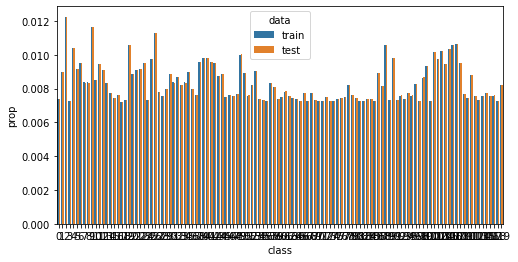

In [22]:
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_label['RaceId']) / train_label.shape[0],
                         np.bincount(test_label['RaceId']) / test_label.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

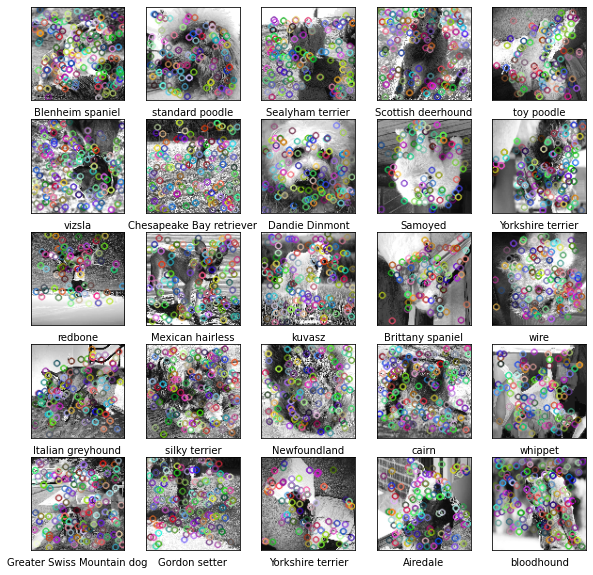

In [23]:
plt.figure(figsize=(10,10))
k=0
for i in train_image.index[:25]:
    plt.subplot(5,5,k+1)
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image['Image'][i])
    plt.xlabel(train_label['Race'][i])
plt.show()

We normalize the data:

In [24]:
train_images = train_image['Image']
test_images = test_image['Image']

train_labels=train_label['RaceId']
test_labels=test_label['RaceId']

The scale of grey is now from 0 to 1.

In [25]:
train_labels.shape

(296352,)

In [26]:
test_labels.shape

(32928,)

###**Creation of a validation set**

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:
* the training set
* the validation set

In [27]:

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)

In [28]:
train_id=train_images.index
valid_id=valid_images.index
test_id=test_images.index

In [29]:
partition = {'train' : [str(i) for i in train_id], 'validation' : [str(i) for i in valid_id]}

labels={}
for i in train_id:
    labels[str(i)]=train_labels[i]
for i in valid_id:
    labels[str(i)]=valid_labels[i]


### We define a class used not to overflow our GPU.

In [32]:
batch_size=256
epochs=200
input_shape=(dim,dim,3)

In [33]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=batch_size, dim=input_shape, n_classes=num_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = data['Image'][int(ID)]

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [34]:
train_images=np.asarray([i.astype(np.float32) for i in train_images])

valid_images=np.asarray([i.astype(np.float32) for i in valid_images])

test_images=np.asarray([i.astype(np.float32) for i in test_images])

input_shape = train_images.shape[1:]

In [35]:
test_labels = to_categorical(test_labels, num_classes)
test_labels=np.asarray([i.astype(np.float32) for i in test_labels])


In [43]:
def create_neural_network(MaxPoolNum=3,PoolSizeList=[(3,3),(3,3),(2,2)],ConvList=[2,2,3],KerSizes=[[(3,3),(3,3)],[(3,3),(3,3)],[(3,3),(3,3),(3,3)]],ConvArgList=[[32,32],[64,64],[128,128,256]],optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],rescaling=True,input_shape=input_shape,dropout_rate=0.75,normalization=False):
    model_temp = Sequential()
    if rescaling:
        model_temp.add(Rescaling(1./255, input_shape=input_shape))
    for k in range(MaxPoolNum):
        for i in range(ConvList[k]):
            if k==0 and i==0:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu', input_shape=input_shape))
            else:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu'))
        if k==0 and normalization==True:
            model_temp.add(LayerNormalization())
        model_temp.add(MaxPooling2D(pool_size=PoolSizeList[k]))


    model_temp.add(Flatten())
    model_temp.add(Dense(num_classes*5, activation='relu'))
    model_temp.add(Dropout(dropout_rate))
    model_temp.add(Dense(num_classes, activation='softmax'))

    model_temp.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    return model_temp


In [37]:
#Generators

training_generator = DataGenerator(partition['train'], labels)
validation_generator = DataGenerator(partition['validation'], labels)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

### Run the models

First model

In [38]:
time0=time.time()
wholemodel_cnn = create_neural_network(MaxPoolNum=3,PoolSizeList=[3,2,2],ConvList=[1,1,1],
                                        KerSizes=[[10],[8],[6]],ConvArgList=[[16],[32],[32]],
                                        optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],
                                        rescaling=True,input_shape=input_shape,dropout_rate=0.4)

wholemodel_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 16)        4816      
                                                                 
 layer_normalization (LayerN  (None, 91, 91, 16)       32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0

In [39]:
# Run the train
wholehistory_cnn = wholemodel_cnn.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/200
358/926 [==========>...................] - ETA: 2:03 - loss: 4.7827 - accuracy: 0.0116   

KeyboardInterrupt: 

In [ ]:
wholescore_cnn = wholemodel_cnn.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_cnn[0])
print('Test accuracy:', wholescore_cnn[1])
time1=time.time()-time0

Second model

In [44]:
time0=time.time()
wholemodel_cnn2 = create_neural_network(MaxPoolNum=3,PoolSizeList=[(3,3),(3,3),(3,3)],ConvList=[2,2,1],
                                        KerSizes=[[(3,3),(3,3)],[(4,4),(3,3)],[(3,3)]],ConvArgList=[[32,32],[64,64],[256]],
                                        optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],
                                        rescaling=True,input_shape=input_shape,dropout_rate=0)


wholemodel_cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        32832     
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 64)        36928     
                                                      

In [ ]:
# Run the train
wholehistory_cnn2 = wholemodel_cnn2.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/200
926/926 [==============================] - 89s 96ms/step - loss: 4.5553 - accuracy: 0.0326 - val_loss: 4.3890 - val_accuracy: 0.0522

In [ ]:
wholescore_cnn2 = wholemodel_cnn2.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_cnn2[0])
print('Test accuracy:', wholescore_cnn2[1])
time1=time.time()-time0

# Re-training du VGG16

In [ ]:
from keras.applications import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(num_classes*10, activation='relu')
dense_layer_2 = layers.Dense(num_classes*5, activation='relu')
dropout_layer = layers.Dropout(0.25)
prediction_layer = layers.Dense(num_classes, activation='softmax')


wholemodel = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

wholemodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

wholehistory_model=wholemodel.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

In [ ]:
wholescore_model = wholemodel.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', wholescore_model[0])
print('Test accuracy:', wholescore_model[1])


In [ ]:
# summarize history for accuracy

def history_accuracy(history_model):
  history = history_model
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss

def history_loss(history_model):
  history = history_model
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
#Loss
print("1st CNN MODEL: ")
history_loss(wholehistory_cnn)
print("2nd CNN MODEL:")
history_loss(wholehistory_cnn2)
print("VGG16 MODEL: ")
history_loss(wholehistory_model)


In [ ]:
# Accuracy
print("1st CNN MODEL: ")
history_accuracy(wholehistory_cnn)
print("2nd CNN MODEL:")
history_accuracy(wholehistory_cnn2)
print("VGG16 MODEL: ")
history_accuracy(wholehistory_model)



In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CNN = ['CNN 2', 'VGG16']
Test_Accuracy = [wholescore_cnn2[1],wholescore_model[1]]
ax.bar(CNN,Test_Accuracy)
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    true_label_temp, img_temp = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_temp)

    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)
    if predicted_label == np.argmax(true_label_temp):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label2]),
                                color=color)



def plot_value_array(i, predictions_array, true_label):
    true_label_temp = true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label2].set_color('blue')

In [ ]:
def plot_prediction_images(prediction):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range (num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, prediction[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, prediction[i], test_labels)
    plt.tight_layout()
    plt.show()

In [ ]:
def create_neural_network(MaxPoolNum=3,PoolSizeList=[(3,3),(3,3),(2,2)],ConvList=[2,2,3],KerSizes=[[(3,3),(3,3)],[(3,3),(3,3)],[(3,3),(3,3),(3,3)]],ConvArgList=[[32,32],[64,64],[128,128,256]],optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],rescaling=True,input_shape=input_shape,dropout_rate=0.75):
    model_temp = Sequential()
    if rescaling:
        model_temp.add(Rescaling(1./255, input_shape=input_shape))
    for k in range(MaxPoolNum):
        for i in range(ConvList[k]):
            if k==0 and i==0:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu', input_shape=input_shape))
            else:
                model_temp.add(Conv2D(ConvArgList[k][i],kernel_size=KerSizes[k][i],activation='relu'))
        if k==0:
            model_temp.add(LayerNormalization())
        model_temp.add(MaxPooling2D(pool_size=PoolSizeList[k]))


    model_temp.add(Flatten())
    model_temp.add(Dense(num_classes*5, activation='relu'))
    model_temp.add(Dropout(dropout_rate))
    model_temp.add(Dense(num_classes, activation='softmax'))

    model_temp.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    return model_temp